<a href="https://colab.research.google.com/github/huggingface/data-is-better-together/blob/main/prompt_translation/setup_prompt_translation_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install huggingface_hub argilla datasets openai -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.

# Steps

The overall steps to create a new Argilla Space for translating a new language are as follows:

1. Setup an organization on the Hub
2. Create an Argilla Space
3. Setup the Space secrets
4. Load the DIBT data into the Argilla Space
5. Begin translating the data!


This notebook will walk through each of these steps. Some of the steps are done using the `huggingface_hub` CLI, other parts of the process can only be done in the UI, but we will also show how to do them using the API.




In [2]:
from huggingface_hub import duplicate_space
from huggingface_hub import hf_hub_download
from huggingface_hub import HfApi
from huggingface_hub import SpaceCard
import yaml
import json

## 1. Create a new organization for your language effort

To make it easier to keep track of your language effort, we recommend creating a new organization for your language effort. This will allow you to keep all of your language effort data in one place. We suggest naming this organization "DIBT-{language}" where `{language}` is the name of your language. For example, if you are working on the language "Spanish", you would name your organization "DIBT-Spanish". This will make it easier for us to track all of the DIBT language efforts.

You can use this link to create a new organization on the Hub: [https://huggingface.co/organizations/new](https://huggingface.co/organizations/new).

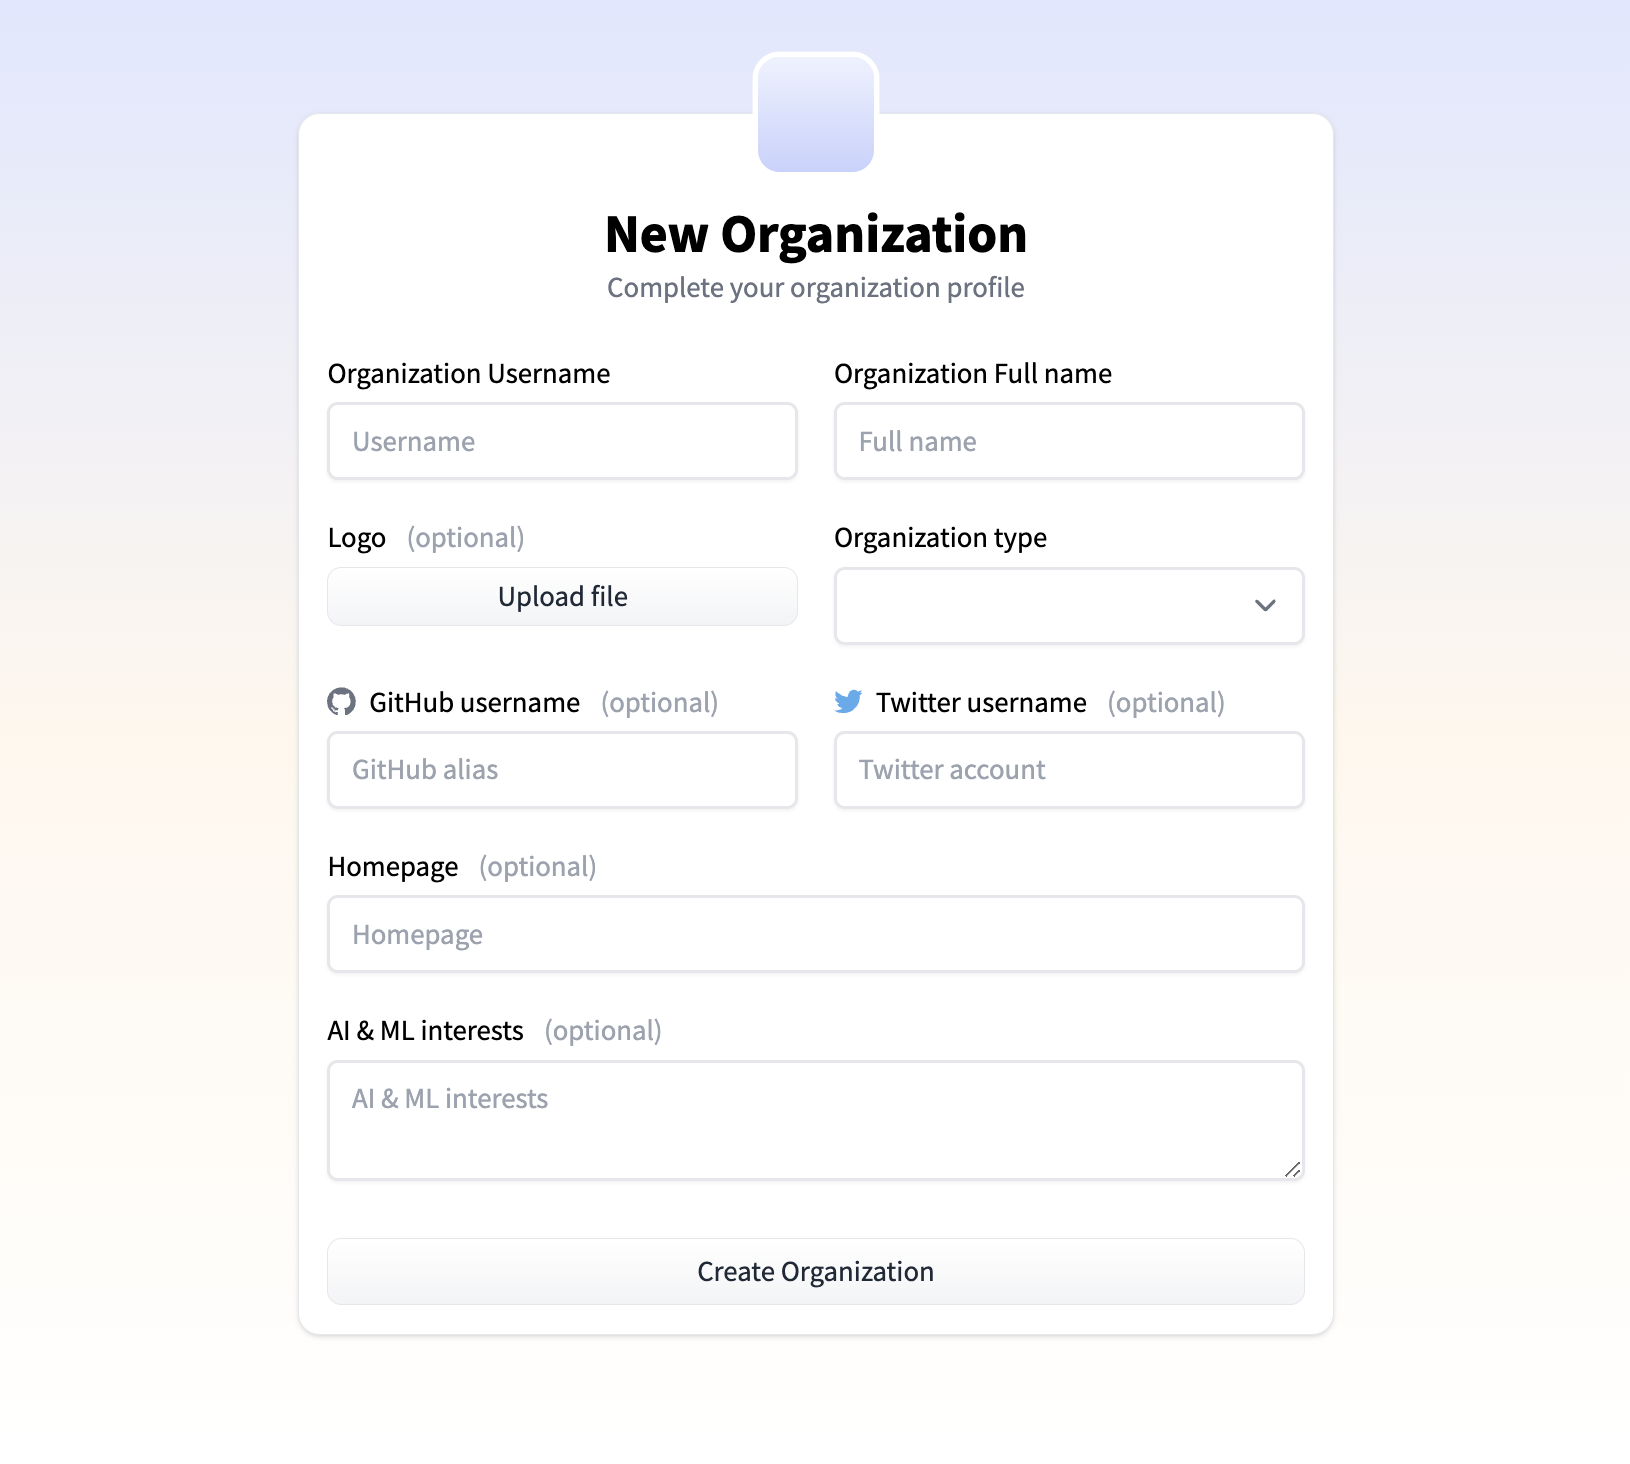



<div class="alert alert-warning">
  <strong>Tip!</strong> Make sure you update this section with your details
</div>

In [ ]:
HF_ORG_NAME = None # update with the ID of the org you just created
LANGUAGE = None # update this with the language you will work on

In [ ]:
assert HF_ORG_NAME is not None, "Please set HF_ORG_NAME to the ID of the Hugging Face org you just created"
assert LANGUAGE is not None, "Please set LANGUAGE to the language your effort focuses on"

*Note** please ping `@dvs13` in the Discord channel once you have created your organization.

## 2. Setup the Space

We will use the `huggingface_hub` CLI to create a new Space for our language effort by cloning an existing template Space. We could also do this via the UI but we'll also update some of the settings using the API in this notebook to reduce the amount of steps you need to do in the UI. Before we do this we need to authenticate with the Hub.

In [ ]:
from huggingface_hub import login

In [ ]:
login()

In [ ]:
api = HfApi()

This step duplicates the existing Argilla Space to your organization.

In [ ]:
from_id = "argilla/argilla-template-space-with-oauth"
to_id =  f"{HF_ORG_NAME}/prompt-translation-for-{LANGUAGE}"
new_space = duplicate_space(from_id, to_id=to_id)
new_space

We update the tile and description of the Space to reflect the language we are translating.

In [ ]:
card = SpaceCard.load(to_id)
card.data.title = f"DIBT Translation for {LANGUAGE}"
card.push_to_hub(to_id)

## 3. Create an application on the Hub

To enable the Oauth integration we need to create an application on the Hub. We can do this via the Hugging Face settings UI.

- Go to this page: [https://huggingface.co/settings/applications/new](https://huggingface.co/settings/applications/new)
- Complete the form to create a new application. You will need to provide the following values:
    - Name of application
    - Homepage URL: Your Argilla Space Direct URL.
    - Logo URL: [Your Argilla Space Direct URL]/favicon.ico
    - Scopes: openid and profile.
    - Redirect URL: [Your Argilla Space Direct URL]/oauth/huggingface/callback

The cell below will show you the URL for these values.



In [ ]:
homepage_url = f"https://{new_space.repo_id.lower().replace('/', '-')}.hf.space"
favicon_url = f"{homepage_url.lower()}/favicon.ico"
redirect_url = f"{homepage_url.lower()}/oauth/huggingface/callback"
print(f"Homepage URL: {homepage_url.lower()} \n Logo URL: {favicon_url} \n Redirect URL: {redirect_url}")

Homepage URL: https://somosnlp-prompt-translation-for-spanish.hf.space 
 Logo URL: https://somosnlp-prompt-translation-for-spanish.hf.space/favicon.ico 
 Redirect URL: https://somosnlp-prompt-translation-for-spanish.hf.space/oauth/huggingface/callback


## 4. Setup your Space secrets

Once we have created the application we will need to update our Space secrets to add these values which will be shown once you've created your application using the steps above.

- `OAUTH2_HUGGINGFACE_CLIENT_ID`: [Your Client ID]
- `OAUTH2_HUGGINGFACE_CLIENT_SECRET` : [Your App Secret]

Additionally, we highly recommend setting up a custom API_KEY and PASSWORD for the owner role (you). This owner role would be the only one allowed to create, delete, read and update datasets, so it's important to change the defaults:

- `OWNER_API_KEY`: you can put any alphanumeric value
- `OWNER_PASSWORD`: at least 8 digits/characters.

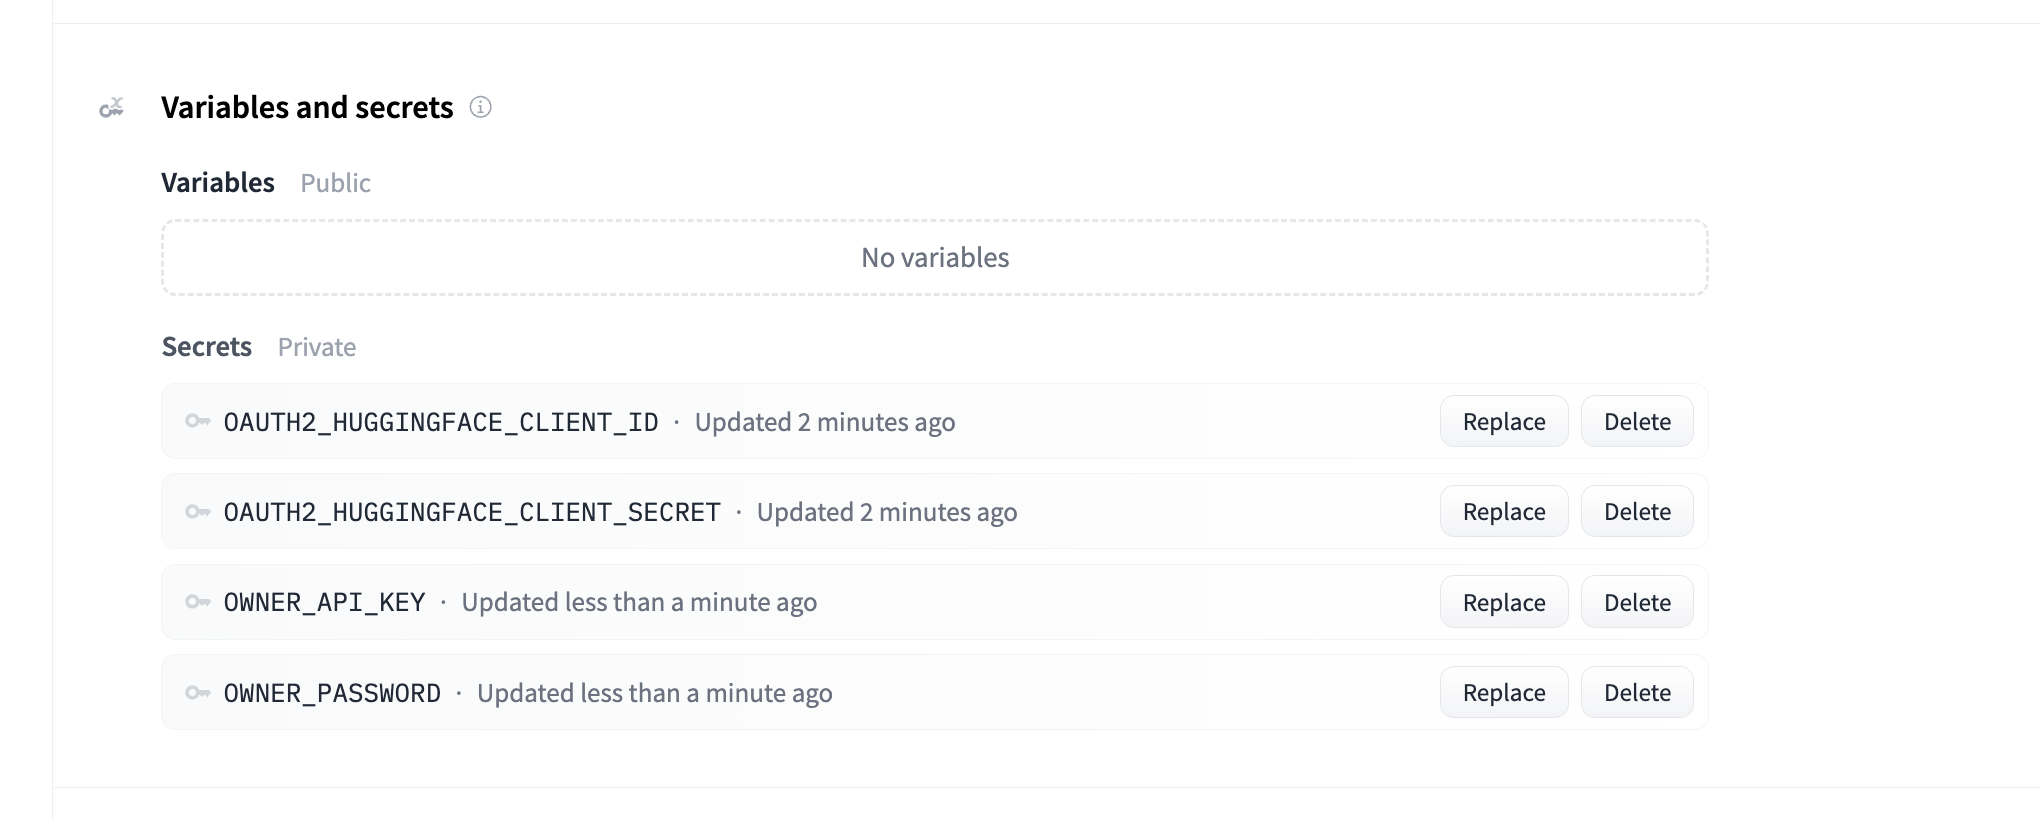


You can add these secrets via the `settings` tab in the UI. Run the cell below and click on the link:

In [ ]:
print(f"https://huggingface.co/spaces/{to_id}/settings")

https://huggingface.co/spaces/somosnlp/prompt-translation-for-Spanish/settings


## 5. Persistent Storage + Upgrade CPU

To ensure all annotations are safely stored we'll want to enable persistent storage on our Space. This means that if the Space is stopped and restarted, all annotations will still be available. Please ping @dvs13 on Discord to enable this feature for your Space.

Additionally, we'll upgrade the CPU and disable sleeping to ensure the Space is always available for annotators!

We now need to factory reset the Space to ensure all of the above changes register.

In [ ]:
from huggingface_hub import restart_space

restart_space(to_id, factory_reboot=True)

## 6. Testing your Space

At this point you are ready to verify the installation. You need to go to following Space URL

In [ ]:
print(f"https://huggingface.co/spaces/{to_id}")

https://huggingface.co/spaces/somosnlp/prompt-translation-for-Spanish


You should see something like this:

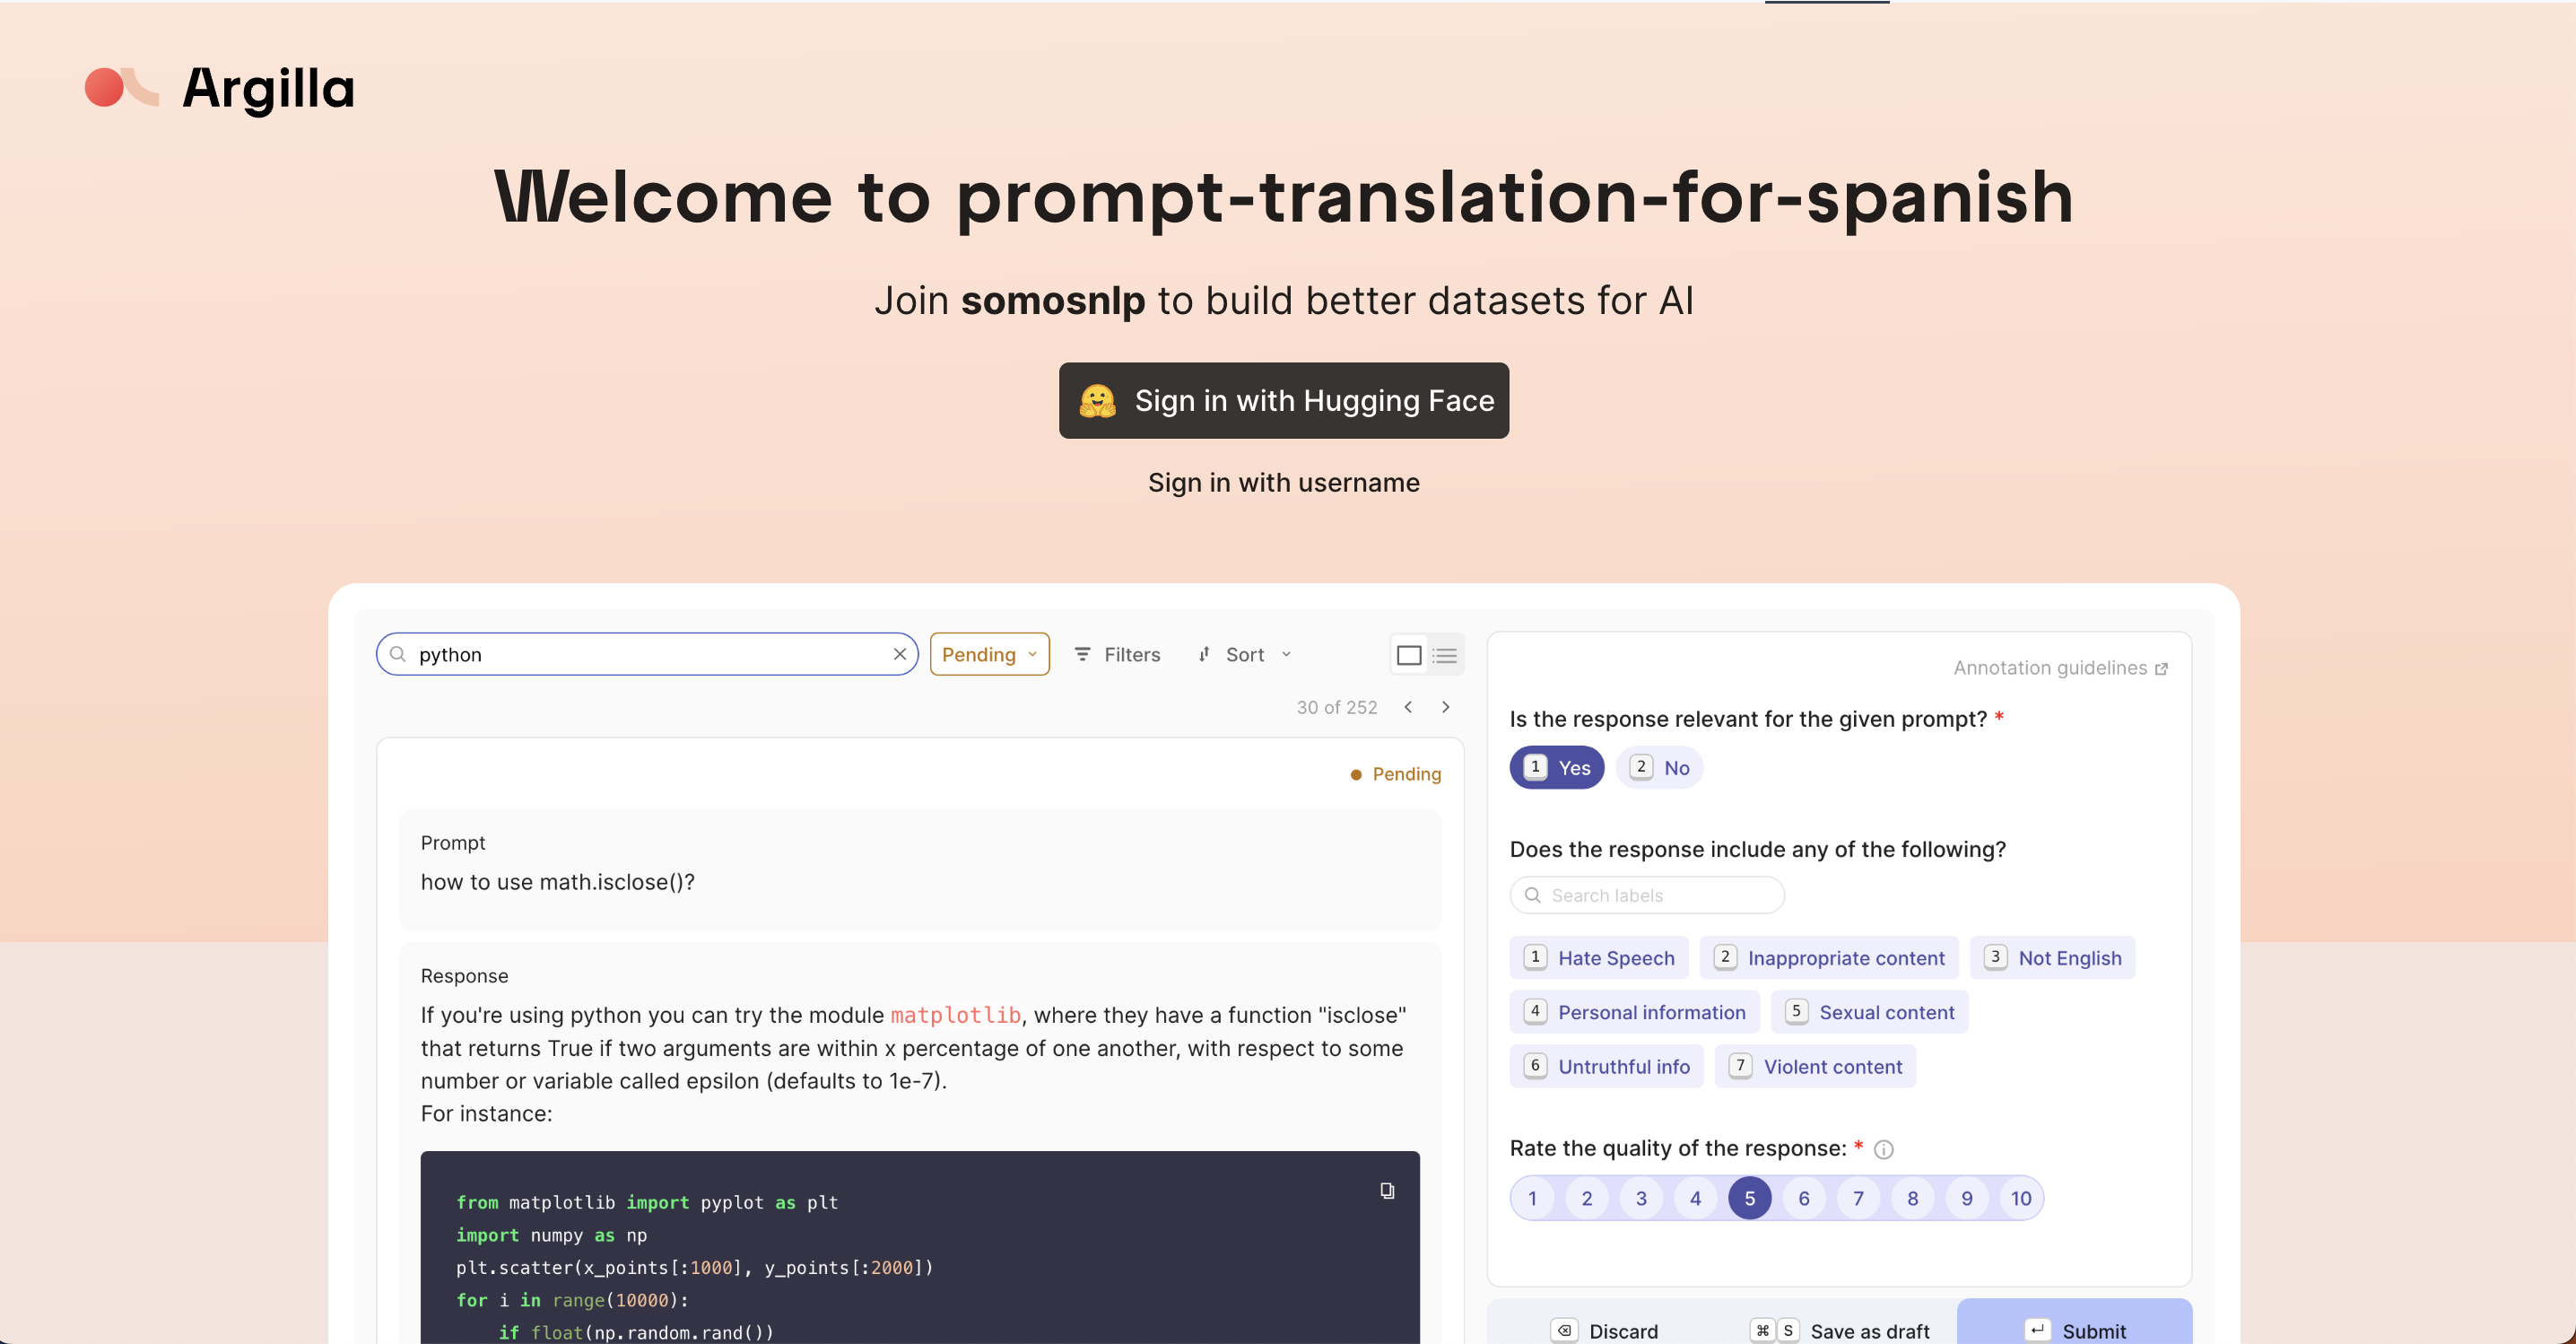

If you don't see the Sign in with Hugging Face button, you need to go back to Steps 3 and 4 to make sure the OAuth app is correctly set up (make sure the callback URL is correct) and the secret are correct.

The next step is to test the Sign in, you should see something like this:




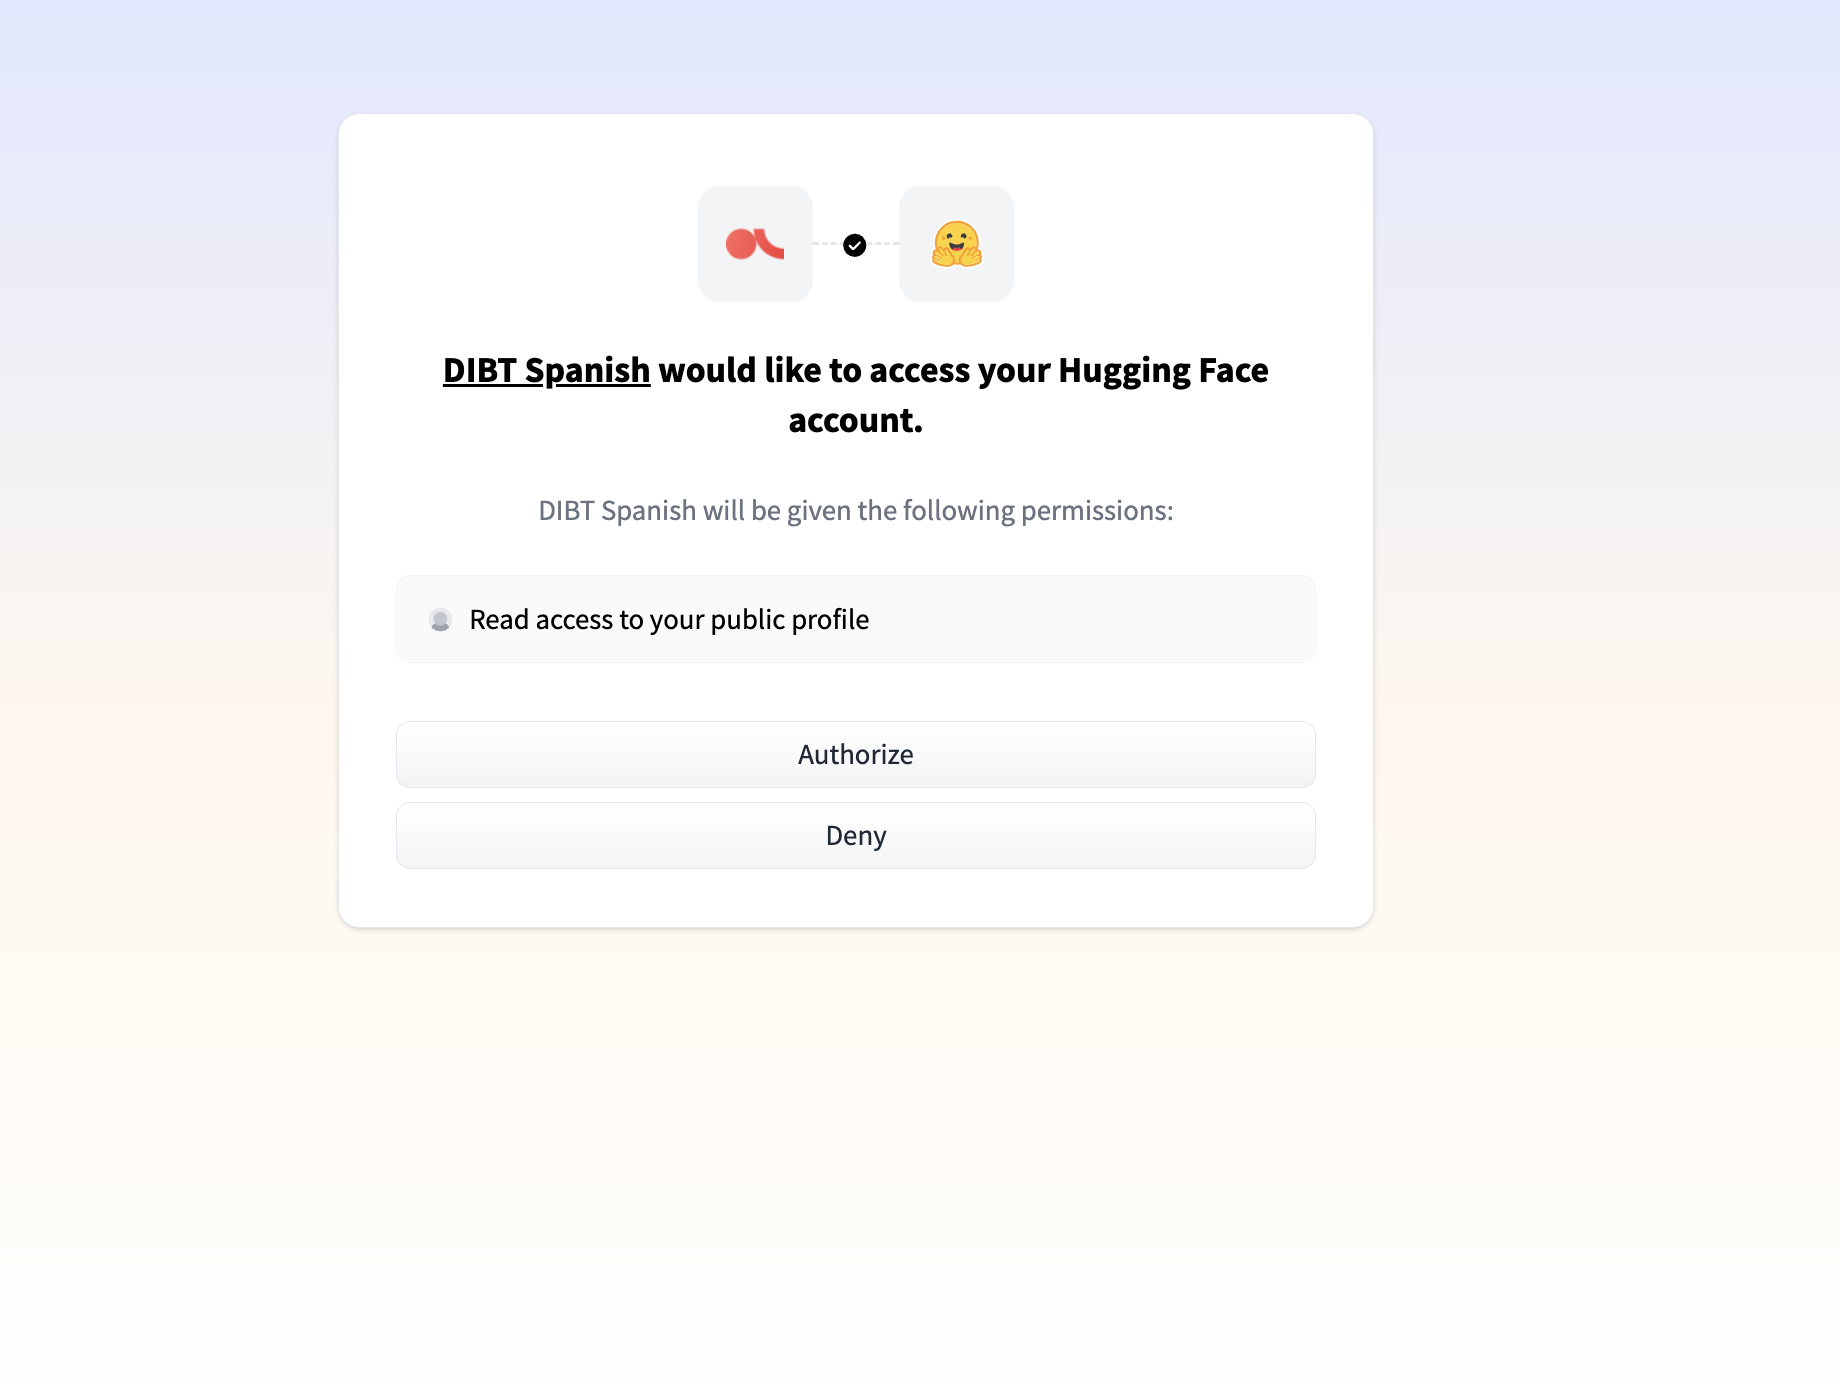

If you see an error after Authorizing, please double check the callback URL on your OAuth application settings at [https://huggingface.co/settings/connected-applications](https://huggingface.co/settings/connected-applications)

## 7. Load the DIBT data into the Argilla Space


First we need to set up the Argilla SDK client with the URL and owner credentials for our space

<div class="alert alert-warning">
  <strong>Warning!</strong> Make sure you have persistent storage enabled before you proceed to the next steps, if you haven't done this there is a strong danger of losing data. Please reach out on Discord to make sure this step has been done!
</div>

In [12]:
from huggingface_hub import space_info
assert space_info(to_id).runtime.storage.get("current") == "small", "Please ensure you have setup persistent storage for your space. Please see steps above"

In [ ]:
import argilla as rg

OWNER_API_KEY = "owner.apikey" # if you haven't setup the secret this is the default owner api key
assert OWNER_API_KEY is not None, "Please set OWNER_API_KEY to the API token you just set in the Space settings"

rg.init(api_url=homepage_url, api_key=OWNER_API_KEY)

Finally, we're ready to create our dataset in the `admin` workspace. To test that everything is working let's upload the original dataset (without translation), you can later delete this dataset from the UI or via the SDK.

In [ ]:
from datasets import load_dataset

# load the dataset from the Hub
ds = load_dataset('DIBT/prompts_ranked_multilingual_benchmark')

In [ ]:
# create the dataset with a pre-built template
argilla_ds = rg.FeedbackDataset.for_translation(
    use_markdown=True,
    guidelines=None,
    metadata_properties=None,
    vectors_settings=None,
)
argilla_ds

In [ ]:
# create records
records = []
for row in ds["train"]:
    record = rg.FeedbackRecord(
        fields={"source": row["prompt"]},
        metadata=json.loads(row["metadata"]),
        external_id=row["row_idx"],
    )
    records.append(record)

In [ ]:
# add records to the dataset
argilla_ds.add_records(records)

In [ ]:
# push the dataset to Argilla
argilla_ds.push_to_argilla(f"DIBT Translation for {LANGUAGE}", workspace="admin")

At this point, the dataset is available in the UI. To be able to delete you need to log in with the user `owner` and the password you have setup in the secrets or the default one which is `12345678` if you haven't added the secret.

## 8. Translate the source dataset and push it to Argilla

The only remaining step is to translate the dataset and create the final dataset your contributors will be annotating.

There are different options to translate the dataset, such as:

- Using Open Source models, like: nllb-200, Google-T5, OPUS-MT
- Using Closed LLM API providers like OpenAI with gpt-4-turbo or Mistral with mistral-large

### Translation models

#### Open Source models

We will first start with an example of a translation pipeline with open source models. Even though these models are able to run on CPU it is highly recommended to use a GPU in order to speed up inference.

We will use the [No Language Left Behind (NLLB) intiative from Meta](https://ai.meta.com/blog/nllb-200-high-quality-machine-translation/). A distilled version of this [model is available on Hugging Face](https://huggingface.co/facebook/nllb-200-distilled-600M). This model workd accross 200 different language and their language codes can be found in [this readme](https://huggingface.co/facebook/nllb-200-distilled-600M/blob/main/README.md).

First, we will initialize the model with a correct `src_lang`.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

model_path = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_path, src_lang="eng_Latn")
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Check if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model and tokenizer to the GPU if available
model = model.to(device)

Order of the Ministry of Finance of the Russian Federation of 10.08.2023 No 129n " On the declaration of the orders of the Ministry of Finance of the Russian Federation as having lost its force "


Next, we will define a translation function that takes a `text: Union[str, List[str]]` and a correct `trg_lang`.

In [ ]:
def open_translate(texts, trg_lang):
    if isinstance(texts, str):  # If a single text is provided, convert it to a list
        texts = [texts]

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    translated_tokens = model.generate(
        **inputs.to(device), forced_bos_token_id=tokenizer.lang_code_to_id[trg_lang]
    )
    translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

    if len(translations) == 1:
        return translations[0]
    else:
        return translations


example = "We will first start with an example of a translation pipeline with open source models. Even though these models are able to run on CPU it is highly recommended to use a GPU in order to speed up inference."
open_translate(example, "spa_Latn")

'Comenzaremos con un ejemplo de una tubería de traducción con modelos de código abierto. Aunque estos modelos pueden funcionar en CPU, es muy recomendable usar una GPU para acelerar la inferencia.'

#### Other models and closed source LLM API providers

Depending on the language you are working in the NLLB model used above might not work so well. One alternative is to use a specific translation model for your language. You can find many of these on the Hugging Face Hub with examples showing how to use them. Alternatively, you might use a closed LLM provider. We provide a separate example of using one of these notebooks [here](https://github.com/huggingface/data-is-better-together/blob/main/prompt_translation/Translation_with_distilabel_gpt_4_turbo.ipynb). If you want to use this alternative approach you may want to jump straight to that notebook and skip the rest of this notebook!

### Add translations as suggestions

Now, we will use the defined translation functions to add some pre-filled translation suggestions to the Argilla dataset.

In [ ]:
argilla_ds = rg.FeedbackDataset.from_argilla(f"DIBT Translation for {LANGUAGE}", workspace="admin")
argilla_ds

Next, we will loop through the records and add a translation.

In [ ]:
from tqdm.auto import tqdm

In [ ]:
altered_records = []
for rec in tqdm(argilla_ds.records):
    rec.suggestions = [
        {
            "question_name": "target",
            "value": open_translate(rec.fields["source"], "spa_Latn")
        }
    ]
    altered_records.append(rec)

Lastly, we will update these records within Argilla.

In [ ]:
# Example of doing this with a closed model
# altered_records = []
# for rec in tqdm(argilla_ds.records):
#     rec.suggestions = [
#         {
#             "question_name": "target",
#             "value": closed_translate(
#                 rec.fields["source"],
#                 "spa_Latn",
#                 max_tokens=len(rec.fields["source"]) + 10,
#             ),
#         }
#     ]
#     altered_records.append(rec)

In [ ]:
argilla_ds.update_records(altered_records)

## 9. Create a dashboard to track the annotation efforts

Once you have your annotation suite running on a Hugging Face Space, you can easily set up an dashboard for tracking the annotation effort. Check out how the Spanish one looks like!

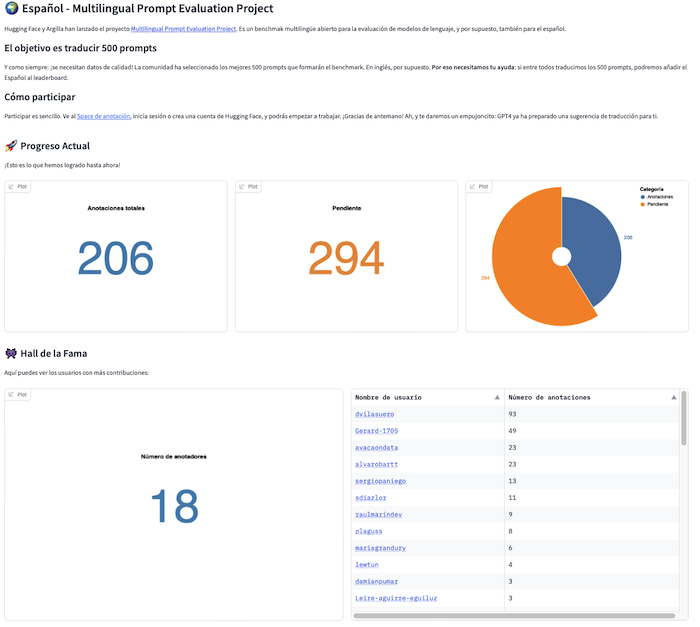

There are some variables that you need to gather first, as they are used to obtain the data from the annotation space. They are:

- `SOURCE_DATASET`: The dataset id of the source dataset
- `SOURCE_WORKSPACE`: The workspace id of the source dataset
- `TARGET_RECORDS`: The number of records that you have as a target to annotate. We usually set this to 500.
- `ARGILLA_API_URL`: Link to the Huggingface Space where the annotation effort is being hosted. For example, the Spanish one is https://somosnlp-dibt-prompt-translation-for-es.hf.space/
- `ARGILLA_API_KEY`: The API key to access the Huggingface Space. Please, write this as a secret in the Huggingface Space configuration.

Once this is done, you can find an example of a dashboard application in the folder `dashboard_template`. With a few tweaks, it'll be up and running.

First, within your organization, please create a new Hugging Face Space with Gradio. The free configuration is enough. Then, set the previous variables as environment variables within the Space configuration, with `ARGILLA_API_KEY` as a secret. 

Then, you have to upload and push the dashboard template. There are several ways to do it, but we recommend either uploading it directly through the Hugging Face Space website, or cloning the repository and pushing it from your favorite code editor. Note that the template needs to be translated to the language of your choice, both the constants at the beggining of `app.py` and the Markdown content at the end of the same file. Push it, and the dashboard should be ready!

Do not hesitate to share with us the API URL and API KEY of your annotation suite and your dashboard, and we will include the details of your annotation effort in our global tracker and our GitHub page.